# Horizontally integrate multiple scRNA-seq samples
**Author**: Adam Klie (last modified: 10/12/2023)<br>
***
**Description**: This script 

In [2]:
# Python packages
import os
import seaborn as sns
import anndata as ad
import glob
import scanpy as sc

import scib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# R interface
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
import rpy2.rinterface_lib.callbacks

# Activate R interface
pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


In [3]:
# List h5ads to integrate
results_paths = [
    "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control",
    "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/A2_control",
]

In [4]:
# List h5ads to integrate
h5ad_paths = []
for results_path in results_paths:
    h5ad_paths += glob.glob(os.path.join(results_path, "*", "rna", "annotate", "*.h5ad"))
len(h5ad_paths), h5ad_paths

(6,
 ['/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo38/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo29/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo14/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo22/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo3/rna/annotate/annotate.h5ad',
  '/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/20Oct23/H1_control/mo1/rna/annotate/annotate.h5ad'])

In [5]:
# Read in samples
adata_list = []
samples = []
for h5ad_path in h5ad_paths:
    sample = h5ad_path.split("/")[-4]
    adata = sc.read_h5ad(h5ad_path)
    adata.obs.index = sample + "_" + adata.obs.index
    adata_cp = sc.AnnData(adata.layers["soupX_counts"].copy(), obs=adata.obs.copy(), var=adata.var.copy())
    adata_list.append(adata_cp)
    samples.append(sample)
samples

['mo38', 'mo29', 'mo14', 'mo22', 'mo3', 'mo1']

In [6]:
# Concat samples
adata_concat = ad.concat(adata_list, label="sample", keys=samples)
adata_concat.obs["sample"].value_counts()

mo38    6092
mo22    4512
mo1     3178
mo3     2834
mo14    2451
mo29    1485
Name: sample, dtype: int64

In [7]:
# What do cell identities look like
adata_concat.obs["manual_cellid_annotation"].value_counts()

SC.EC                    6945
SC.beta                  6791
SC.alpha                 5426
endocrine_progenitor      688
SC.delta                  452
proliferating_alpha       183
pancreatic_progenitor      67
Name: manual_cellid_annotation, dtype: int64

In [8]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_concat.obs["sample"], adata_concat.obs["manual_cellid_annotation"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

manual_cellid_annotation     SC.EC  SC.alpha   SC.beta  SC.delta  \
sample                                                             
mo38                      0.274130  0.396093  0.277085  0.006894   
mo29                      0.297643  0.301684  0.334007  0.030303   
mo14                      0.394941  0.134231  0.361893  0.077519   
mo22                      0.373449  0.218307  0.326463  0.009752   
mo3                       0.375088  0.220536  0.346507  0.023289   
mo1                       0.351479  0.196979  0.398049  0.020453   

manual_cellid_annotation  endocrine_progenitor  pancreatic_progenitor  \
sample                                                                  
mo38                                  0.026592               0.008372   
mo29                                  0.036364               0.000000   
mo14                                  0.023256               0.000000   
mo22                                  0.055629               0.003546   
mo3                                   0.034580               0.000000   
mo1                                   0.020768               0.000000   

manual_cellid_annotation  proliferating_alpha  
sample                                         
mo38                                 0.010834  
mo29                                 0.000000  
mo14                                 0.008160  
mo22                                 0.012855  
mo3                                  0.000000  
mo1                                  0.012272

<Axes: xlabel='sample'>

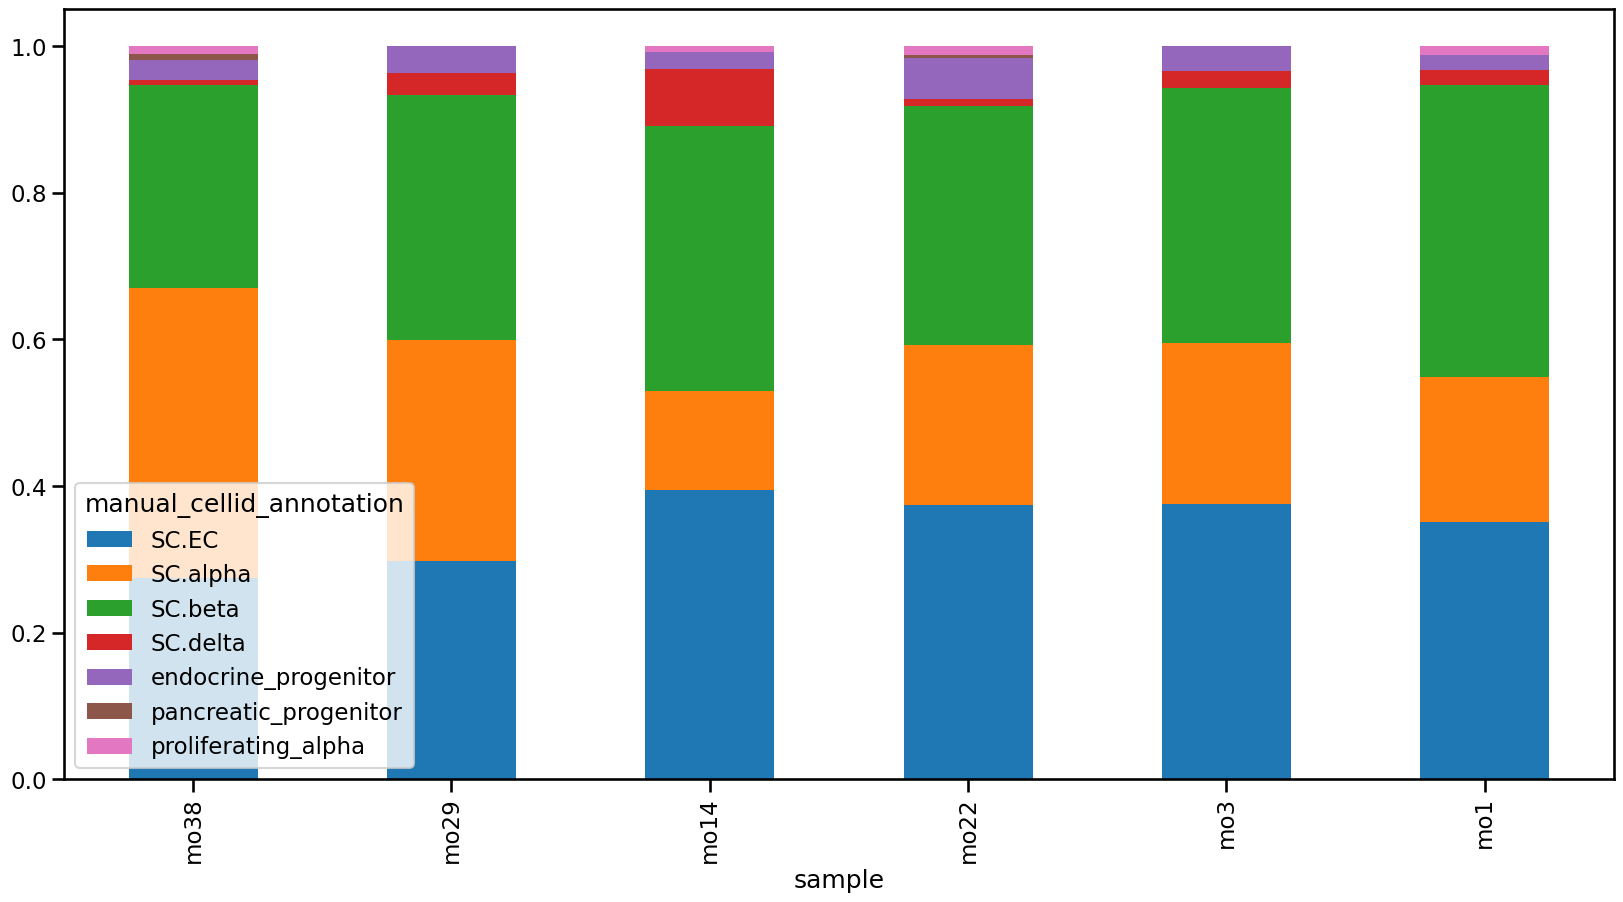

In [9]:
# Make a pretty bar plot with x-axis showing sample and y-axis showing manual_cellid_annotation
cross_tab_norm.plot.bar(stacked=True, figsize=(20, 10))

# Marker genes

In [10]:
# Grab marker genes
marker_genes_df = pd.read_csv("/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/annotation/18Oct23/SC.islet.marker_genes.csv")
marker_genes_dict = marker_genes_df.groupby("cell_id")["gene"].apply(list).to_dict()

# Check markers against adata.var
marker_genes_in_data = dict()
for ct, markers in marker_genes_dict.items():
    markers_found = list()
    for marker in markers:
        if marker in adata_concat.var.index:
            markers_found.append(marker)
    marker_genes_in_data[ct] = markers_found

# Remove any keys with lists of length 0
marker_genes_in_data = {k: v for k, v in marker_genes_in_data.items() if len(v) > 0}

# Output
marker_genes_in_data

{'SC.EC': ['TPH1', 'SLC18A1'],
 'SC.alpha': ['GCG', 'ARX'],
 'SC.beta': ['INS', 'IAPP', 'PDX1'],
 'SC.delta': ['SST'],
 'endocrine_progenitor': ['ZEB2', 'FEV']}

In [11]:
# Set paramaters
batch_key = "sample"
n_comps = 50
n_neighbors = 30
umap_min_dist = 0.3
leiden_resolution = 1
random_state = 1234

In [12]:
# Save counts in adata_concat.raw
adata_concat.raw = adata_concat.copy()

In [13]:
# Save counts in adata_concat.layers["counts"]
adata_concat.layers["counts"] = adata_concat.X.copy()

# Unintegrated log1p normalized data

In [14]:
# Create a copy for unintegrated log1p
adata_log1p = adata_concat.copy()
adata_log1p

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [15]:
# Normalize data based on all cells
sc.pp.normalize_total(adata_log1p)
sc.pp.log1p(adata_log1p)
adata_log1p.layers["logcounts"] = adata_log1p.X.copy()

In [16]:
# Select highly variable genes for PCA
sc.pp.highly_variable_genes(adata_log1p)

In [17]:
# Run PCA
sc.tl.pca(adata_log1p, n_comps=n_comps, svd_solver="arpack", use_highly_variable=True, zero_center=True, dtype="float32", copy=False, random_state=random_state)

In [19]:
# Find neighbors
sc.pp.neighbors(adata_log1p, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [20]:
# Run UMAP
sc.tl.umap(adata_log1p, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [21]:
# Cluster unintegrated data
sc.tl.leiden(adata_log1p, key_added=f"log1p_unintegrated_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [22]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_log1p,
    label_key="manual_cellid_annotation",
    cluster_key="log1p_unintegrated_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca
resolution: 0.1, nmi: 0.7340856794132825
resolution: 0.2, nmi: 0.6983453246148109
resolution: 0.3, nmi: 0.5841766462060152
resolution: 0.4, nmi: 0.5878704306718965
resolution: 0.5, nmi: 0.5725644121753782
resolution: 0.6, nmi: 0.5540815402610768
resolution: 0.7, nmi: 0.5532953504073186
resolution: 0.8, nmi: 0.5375535379822118
resolution: 0.9, nmi: 0.5401986767233498
resolution: 1.0, nmi: 0.5374839227815876
resolution: 1.1, nmi: 0.5344342056645585
resolution: 1.2, nmi: 0.5320113632339935
resolution: 1.3, nmi: 0.5323640818308004
resolution: 1.4, nmi: 0.5295772307752701
resolution: 1.5, nmi: 0.5183843844566381
resolution: 1.6, nmi: 0.5093007709081332
resolution: 1.7, nmi: 0.5010807888785812
resolution: 1.8, nmi: 0.49399370239040663
resolution: 1.9, nmi: 0.4855998851438214
resolution: 2.0, nmi: 0.4818703356791381
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.1
optimal score: 0.7340856794132825


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


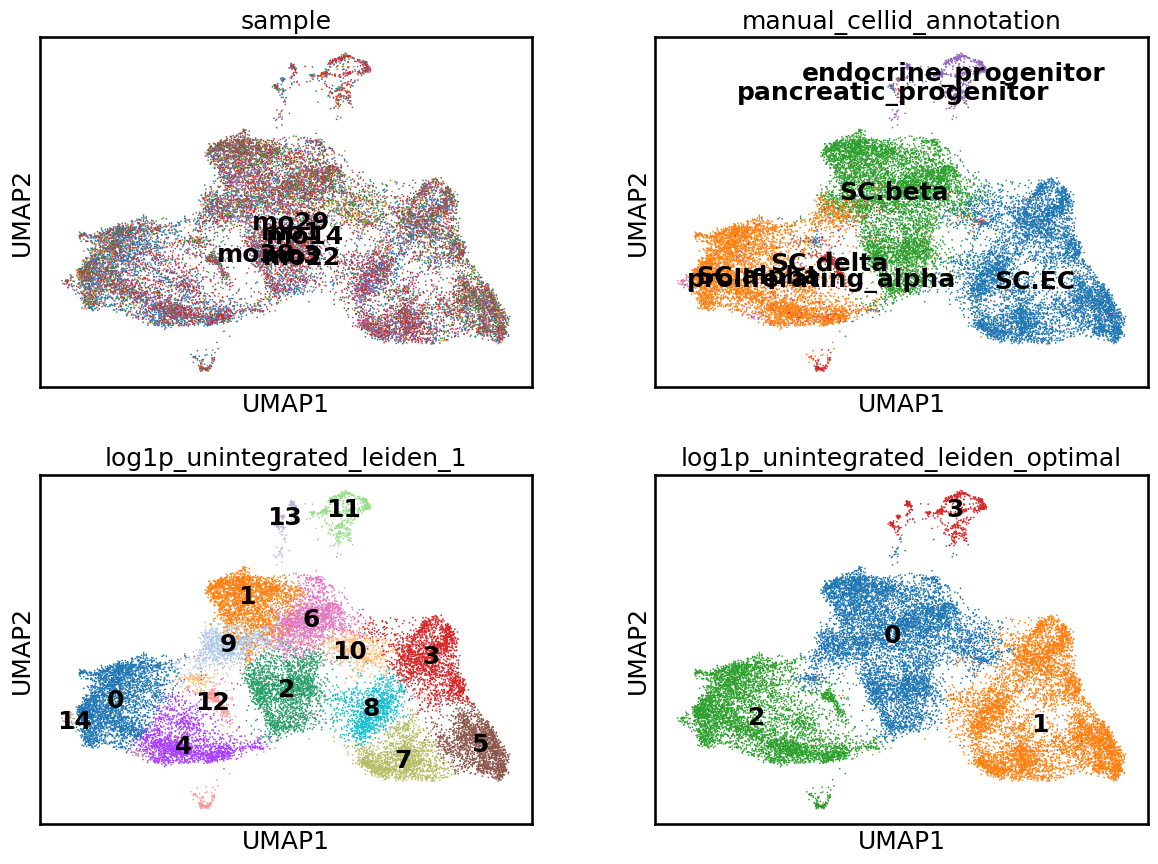

In [24]:
# Plot with sample colors
sc.pl.umap(
    adata_log1p, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"log1p_unintegrated_leiden_{leiden_resolution}", 
        "log1p_unintegrated_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Unintegrated SCTransformed normalized data

In [25]:
%%R
library(Seurat)
library(SeuratObject)
library(Matrix)
library(harmony)

R[write to console]: The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, were retired in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.




    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

R[write to console]: Attaching SeuratObject

R[write to console]: Loading required package: Rcpp



In [52]:
# Make a copy of the original data
adata_sctransform = adata_concat.copy()
adata_sctransform

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [29]:
# Prepare data for Seurat
data_mat = adata_sctransform.layers["counts"].T.astype("float32")
cell_names = adata_sctransform.obs_names
gene_names = adata_sctransform.var_names
metadata = adata_sctransform.obs

In [31]:
# Load into global environment
ro.globalenv["data_mat"] = data_mat
ro.globalenv["cell_names"] = cell_names
ro.globalenv["gene_names"] = gene_names
ro.globalenv["metadata"] = metadata

In [32]:
%%R
mtx = Matrix(data_mat, sparse = TRUE)
rownames(mtx) = gene_names
colnames(mtx) = cell_names
sobj = CreateSeuratObject(counts = mtx, assay = "RNA")
sobj$sample = metadata$sample
sobj = SCTransform(sobj, verbose = FALSE, method = "glmGamPoi")

In [33]:
%%R -o scale_data -o variable_genes
scale_data = GetAssayData(object = sobj, assay = "SCT", slot = "scale.data")
variable_genes = VariableFeatures(object = sobj)

In [53]:
# Create the dataframe
scale_data_df = pd.DataFrame(data=scale_data.T, index=cell_names, columns=variable_genes)

In [54]:
# Add to adata
adata_sctransform.obsm["sctransform_scale_data"] = scale_data_df
adata_sctransform.var["sctransform_genes"] = adata_sctransform.var.index.isin(variable_genes)

In [55]:
# Run PCA on the obsm
adata_sctransform.obsm["X_pca"] = sc.tl.pca(
    adata_sctransform.obsm["sctransform_scale_data"].values, 
    use_highly_variable=False, 
    n_comps=n_comps, 
    svd_solver="arpack", 
    random_state=random_state, 
    zero_center=True, 
    dtype="float32", 
    copy=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [56]:
# Find neighbors on this
sc.pp.neighbors(adata_sctransform, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [57]:
# Run UMAP
sc.tl.umap(adata_sctransform, min_dist=umap_min_dist, random_state=random_state)#, neighbors_key="unintegrated")

In [59]:
# Cluster unintegrated data
sc.tl.leiden(adata_sctransform, key_added=f"sctransform_unintegrated_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state)#, neighbors_key="unintegrated")

In [60]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_sctransform,
    label_key="manual_cellid_annotation",
    cluster_key="sctransform_unintegrated_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca
resolution: 0.1, nmi: 0.8088448101166323
resolution: 0.2, nmi: 0.8247378035411791
resolution: 0.3, nmi: 0.6508293942530173
resolution: 0.4, nmi: 0.5991383629846956
resolution: 0.5, nmi: 0.6022426222966737
resolution: 0.6, nmi: 0.5993972416717414
resolution: 0.7, nmi: 0.5771135235397928
resolution: 0.8, nmi: 0.5674579175625916
resolution: 0.9, nmi: 0.5634422958496604
resolution: 1.0, nmi: 0.5595388010330826
resolution: 1.1, nmi: 0.534026315479579
resolution: 1.2, nmi: 0.52108683007702
resolution: 1.3, nmi: 0.5192819759262055
resolution: 1.4, nmi: 0.5171542599629942
resolution: 1.5, nmi: 0.5156696639670151
resolution: 1.6, nmi: 0.5188824836619204
resolution: 1.7, nmi: 0.5110199544544632
resolution: 1.8, nmi: 0.5027091634496068
resolution: 1.9, nmi: 0.5014802359896493
resolution: 2.0, nmi: 0.49356005582392204
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.2
optimal score: 0.8247378035411791


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


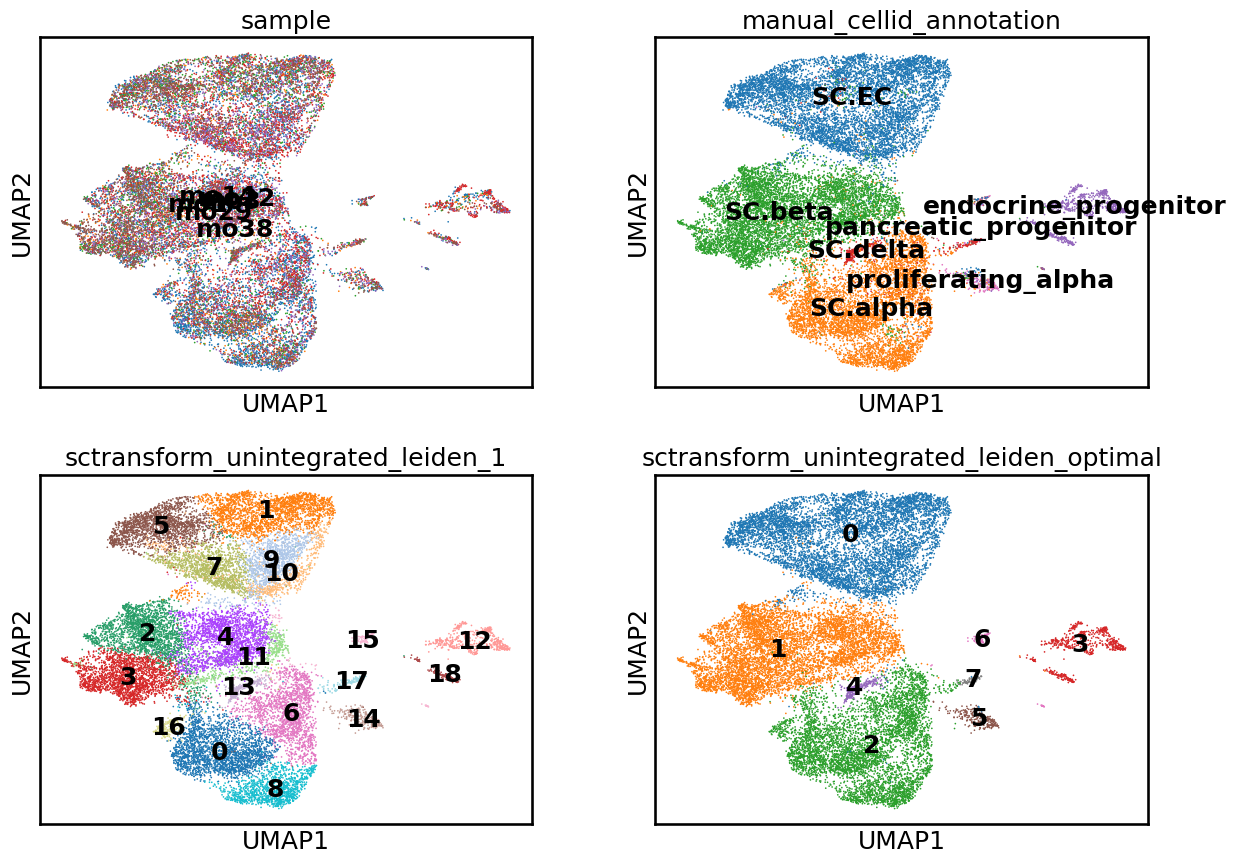

In [61]:
# Plot with sample colors
sc.pl.umap(
    adata_sctransform, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"sctransform_unintegrated_leiden_{leiden_resolution}", 
        "sctransform_unintegrated_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Run Harmony integration in Python

In [62]:
import scanpy.external as sce

In [63]:
# Make another copy, this time of the unintegrated sctransform data
adata_harmony_py = adata_sctransform.copy()
adata_harmony_py

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [64]:
# Run the Python version of Harmony on the PCA from this
sce.pp.harmony_integrate(
    adata=adata_harmony_py,
    basis="X_pca",
    adjusted_basis="X_pca_harmony",
    key="sample",
)

2023-10-21 10:09:03,347 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...


2023-10-21 10:09:15,581 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-21 10:09:15,848 - harmonypy - INFO - Iteration 1 of 10
2023-10-21 10:09:26,963 - harmonypy - INFO - Iteration 2 of 10
2023-10-21 10:09:38,086 - harmonypy - INFO - Iteration 3 of 10
2023-10-21 10:09:49,035 - harmonypy - INFO - Iteration 4 of 10
2023-10-21 10:09:54,658 - harmonypy - INFO - Iteration 5 of 10
2023-10-21 10:09:59,323 - harmonypy - INFO - Iteration 6 of 10
2023-10-21 10:10:04,146 - harmonypy - INFO - Converged after 6 iterations


In [65]:
# Find neighbors
sc.pp.neighbors(
    adata_harmony_py, 
    use_rep="X_pca_harmony", 
    n_neighbors=n_neighbors, 
    n_pcs=n_comps, 
    #key_added="harmony"
    random_state=random_state, 
)

In [66]:
# Run UMAP
sc.tl.umap(adata_harmony_py, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="harmony")

In [67]:
# Cluster unintegrated data
sc.tl.leiden(
    adata_harmony_py, 
    key_added=f"sctransform_harmony_leiden_{leiden_resolution}", 
    resolution=leiden_resolution, 
    random_state=random_state, 
    #neighbors_key="harmony"
)

In [68]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_harmony_py,
    label_key="manual_cellid_annotation",
    cluster_key="sctransform_harmony_leiden_optimal",
    use_rep="X_pca_harmony",
)

Compute neighbors on rep X_pca_harmony
resolution: 0.1, nmi: 0.7747778811639614
resolution: 0.2, nmi: 0.7382295373470269
resolution: 0.3, nmi: 0.6926152538853562
resolution: 0.4, nmi: 0.6339543371115318
resolution: 0.5, nmi: 0.5596351872839832
resolution: 0.6, nmi: 0.556647072572621
resolution: 0.7, nmi: 0.5608442057456042
resolution: 0.8, nmi: 0.5449039095611983
resolution: 0.9, nmi: 0.5449126780991453
resolution: 1.0, nmi: 0.5336817856677118
resolution: 1.1, nmi: 0.5264928132967432
resolution: 1.2, nmi: 0.517500694981576
resolution: 1.3, nmi: 0.5192058309111159
resolution: 1.4, nmi: 0.5150540667529422
resolution: 1.5, nmi: 0.5049273889094481
resolution: 1.6, nmi: 0.5019937345005502
resolution: 1.7, nmi: 0.4995995210106729
resolution: 1.8, nmi: 0.48873844061507044
resolution: 1.9, nmi: 0.4812377943279896
resolution: 2.0, nmi: 0.47833483441093216
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.1
optimal score: 0.7747778811639614


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


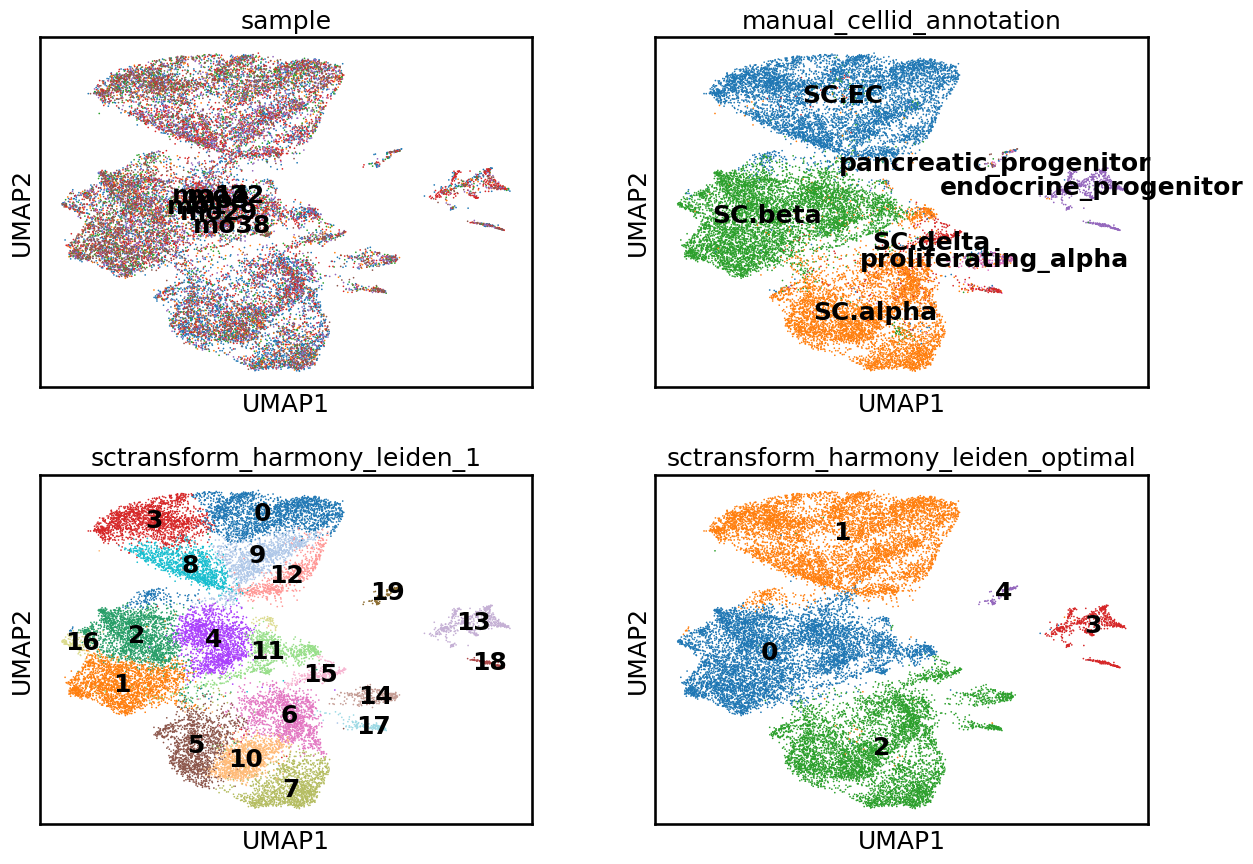

In [69]:
# Plot with sample colors
sc.pl.umap(
    adata_harmony_py, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"sctransform_harmony_leiden_{leiden_resolution}", 
        "sctransform_harmony_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Run Harmony integration in R
Note: you must have run the R code in the SCTransform section to do this

In [70]:
# Make a copy of the original data
adata_harmony_R = adata_sctransform.copy()
adata_harmony_R

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [72]:
%%R -o harmony_embedding 
sobj <- RunPCA(sobj, verbose = FALSE)
sobj <- RunHarmony(
    object = sobj,
    group.by.vars = c('sample'),
    assay.use = 'SCT',
    max.iter.harmony=25,
    project.dim = FALSE
)
harmony_embedding = Embeddings(sobj, reduction = "harmony")

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

In [73]:
# Grab the embedding to use
adata_harmony_R.obsm["X_pca_harmony"] = harmony_embedding

In [74]:
# Find neighbors
sc.pp.neighbors(
    adata_harmony_R, 
    use_rep="X_pca_harmony", 
    n_neighbors=n_neighbors, 
    n_pcs=n_comps, 
    #key_added="harmony"
    random_state=random_state, 
)

In [75]:
# Run UMAP
sc.tl.umap(adata_harmony_R, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="harmony")

In [76]:
# Cluster unintegrated data
sc.tl.leiden(
    adata_harmony_R, 
    key_added=f"sctransform_harmonyR_leiden_{leiden_resolution}", 
    resolution=leiden_resolution, 
    random_state=random_state, 
    #neighbors_key="harmony"
)

In [77]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_harmony_R,
    label_key="manual_cellid_annotation",
    cluster_key="sctransform_harmonyR_leiden_optimal",
    use_rep="X_pca_harmony",
)

Compute neighbors on rep X_pca_harmony
resolution: 0.1, nmi: 0.8001215745332965
resolution: 0.2, nmi: 0.7549824769224596
resolution: 0.3, nmi: 0.6626804549539004
resolution: 0.4, nmi: 0.5997090498879784
resolution: 0.5, nmi: 0.5638498004864927
resolution: 0.6, nmi: 0.5660001479991611
resolution: 0.7, nmi: 0.5618694713586481
resolution: 0.8, nmi: 0.5401534141049417
resolution: 0.9, nmi: 0.531785371139006
resolution: 1.0, nmi: 0.5305147793642951
resolution: 1.1, nmi: 0.5289735113645225
resolution: 1.2, nmi: 0.5187363825294571
resolution: 1.3, nmi: 0.5193269061727721
resolution: 1.4, nmi: 0.5111578618804955
resolution: 1.5, nmi: 0.501964699228258
resolution: 1.6, nmi: 0.5024930849067016
resolution: 1.7, nmi: 0.49840357753593123
resolution: 1.8, nmi: 0.4870422262818511
resolution: 1.9, nmi: 0.4862005071323762
resolution: 2.0, nmi: 0.4833893246728009
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.1
optimal score: 0.8001215745332965


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


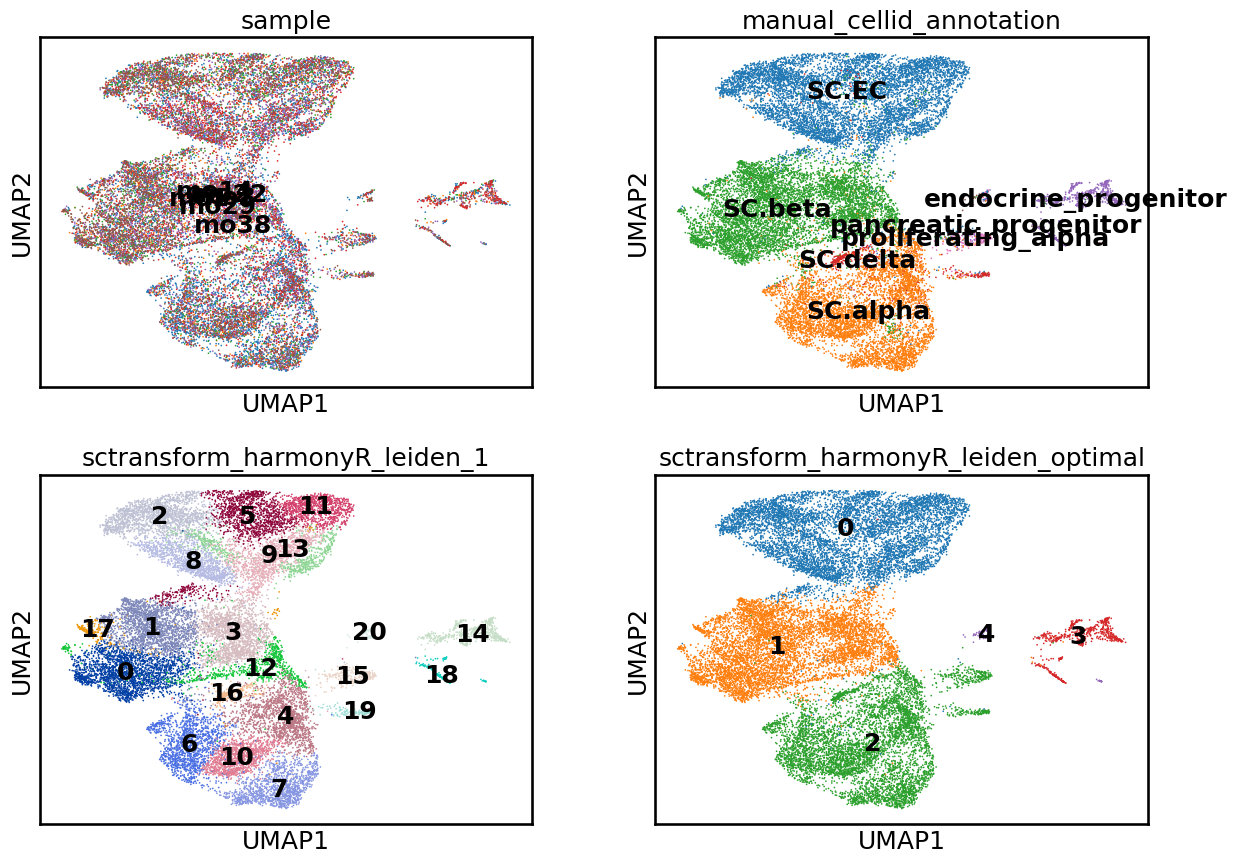

In [79]:
# Plot with sample colors
sc.pl.umap(
    adata_harmony_R, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"sctransform_harmonyR_leiden_{leiden_resolution}", 
        "sctransform_harmonyR_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Seurat integration

In [86]:
# Make another copy
adata_seurat = adata_sctransform.copy()
adata_seurat

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [94]:
%%R
DefaultAssay(sobj) <- "RNA"
sobj.list <- SplitObject(sobj, split.by = "sample")
sobj.list <- lapply(X = sobj.list, FUN = function(x) {
    x <- NormalizeData(x, verbose = FALSE)
    x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000, verbose = FALSE)
})

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to conso

In [97]:
%%R
features <- SelectIntegrationFeatures(object.list = sobj.list)
sobj.anchors <- FindIntegrationAnchors(object.list = sobj.list, anchor.features = features, verbose = FALSE)
sobj.combined <- IntegrateData(anchorset = sobj.anchors, verbose = FALSE)

R[write to console]: Scaling features for provided objects



  |                                                  | 0 % ~calculating   |+++++++++                                         | 17% ~04s           |+++++++++++++++++                                 | 33% ~02s           |+++++++++++++++++++++++++                         | 50% ~01s           |++++++++++++++++++++++++++++++++++                | 67% ~01s           |++++++++++++++++++++++++++++++++++++++++++        | 83% ~01s           |++++++++++++++++++++++++++++++++++++++++++++++++++| 100% elapsed=03s  


R[write to console]: Finding all pairwise anchors



  |                                                  | 0 % ~calculating  

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 6091 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 5166 anchors



  |++++                                              | 7 % ~11m 21s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 8730 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 6633 anchors



  |+++++++                                           | 13% ~09m 21s      

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 4917 anchors

R[write to console]: Filtering anchors



In [102]:
%%R -o integrated_expr
integrated_expr <- GetAssayData(sobj.combined)
integrated_expr <- integrated_expr[, colnames(sobj)]
integrated_expr <- t(integrated_expr)
print(integrated_expr[1:10, 1:10])

10 x 10 sparse Matrix of class "dgCMatrix"


R[write to console]:   [[ suppressing 10 column names ‘AC092957.1’, ‘NFIA’, ‘GPC5’ ... ]]



                                                                     
mo38_AAACATGCAGGCTAAG-1 . . .       . . .      .         . . 2.460156
mo38_AAACATGCATCGTTCT-1 . . .       . . .      .         . . .       
mo38_AAACCAACAACCTGGT-1 . . .       . . .      .         . . .       
mo38_AAACCAACACGCAACT-1 . . .       . . .      .         . . .       
mo38_AAACCAACATAAGTTC-1 . . .       . . .      .         . . .       
mo38_AAACCAACATTGTCCT-1 . . 0.61168 . . .      0.9884446 . . .       
mo38_AAACCGAAGAGGATAT-1 . . .       . . .      .         . . .       
mo38_AAACCGAAGCTCAAAC-1 . . .       . . .      .         . . .       
mo38_AAACCGAAGGCCTGGT-1 . . .       . . .      .         . . .       
mo38_AAACCGCGTCCTAACT-1 . . .       . . 2.9796 .         . . .       


In [108]:
# Add to adata
adata_seurat.obsm["seurat_integrated"] = integrated_expr.A
print(adata_seurat)

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [111]:
# Run PCA on the obsm
adata_seurat.obsm["X_pca"] = sc.tl.pca(
    adata_seurat.obsm["seurat_integrated"], 
    use_highly_variable=False, 
    n_comps=n_comps, 
    svd_solver="arpack", 
    random_state=random_state, 
    zero_center=True, 
    dtype="float32", 
    copy=False
)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


In [112]:
# Find neighbors
sc.pp.neighbors(adata_seurat, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [113]:
# Run UMAP
sc.tl.umap(adata_seurat, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [114]:
# Cluster unintegrated data
sc.tl.leiden(adata_seurat, key_added=f"seurat_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [115]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_seurat,
    label_key="manual_cellid_annotation",
    cluster_key="seurat_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca
resolution: 0.1, nmi: 0.7905327733063015
resolution: 0.2, nmi: 0.7327824264551248
resolution: 0.3, nmi: 0.6764182040425312
resolution: 0.4, nmi: 0.6203150998693777
resolution: 0.5, nmi: 0.6154723802606828
resolution: 0.6, nmi: 0.6008750867994536
resolution: 0.7, nmi: 0.568064141759073
resolution: 0.8, nmi: 0.5519850594176311
resolution: 0.9, nmi: 0.5634156279333701
resolution: 1.0, nmi: 0.548218245871047
resolution: 1.1, nmi: 0.5406495308149172
resolution: 1.2, nmi: 0.5389852796957469
resolution: 1.3, nmi: 0.5182167311640347
resolution: 1.4, nmi: 0.5100429704786266
resolution: 1.5, nmi: 0.4920300960722655
resolution: 1.6, nmi: 0.492546965736403
resolution: 1.7, nmi: 0.494501749669115
resolution: 1.8, nmi: 0.48768778152314474
resolution: 1.9, nmi: 0.4881557657119439
resolution: 2.0, nmi: 0.4852370037146799
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.1
optimal score: 0.7905327733063015


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


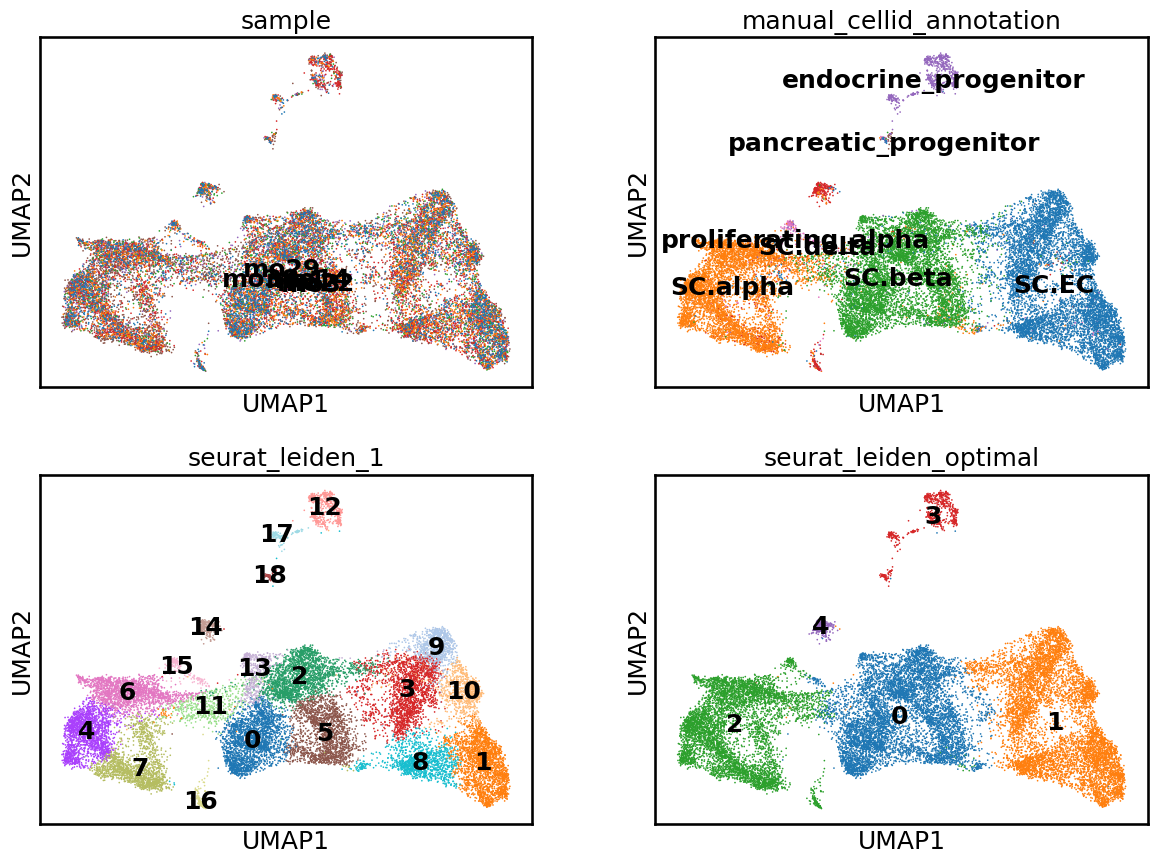

In [117]:
# Plot with sample colors
sc.pl.umap(
    adata_seurat, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"seurat_leiden_{leiden_resolution}", 
        "seurat_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Seurat RPCA
TODO

# ComBat

In [119]:
# Make another copy
adata_combat = adata_concat.copy()
adata_combat

AnnData object with n_obs × n_vars = 20552 × 15112
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'a

In [120]:
# Correct with combat
corrected_X = sc.pp.combat(
    adata_combat,
    key="sample",
    inplace=False,
)

In [123]:
# Add to adata
adata_combat.layers["combat"] = corrected_X
adata_combat.X = corrected_X

In [133]:
# Select highly variable genes for PCA
sc.pp.highly_variable_genes(adata_combat, flavor="cell_ranger", n_top_genes=3000)

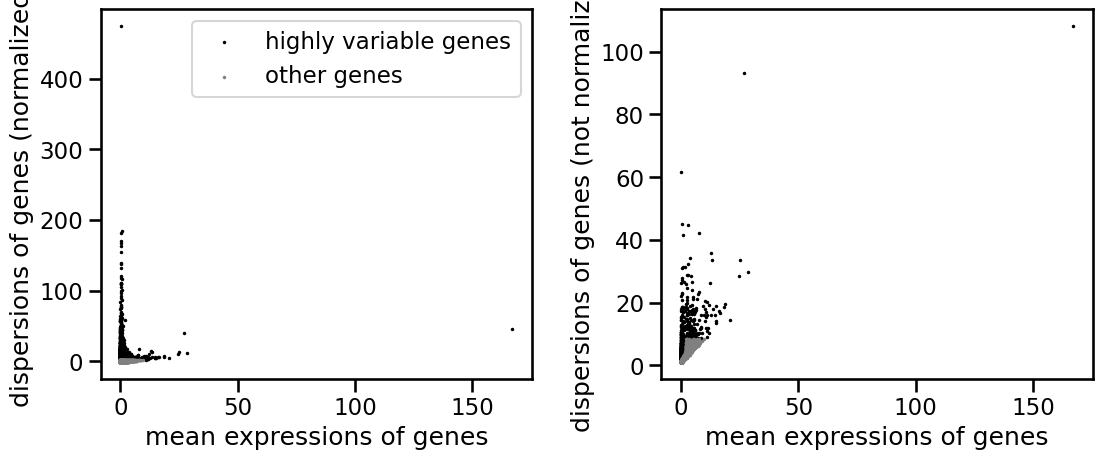

In [141]:
# See what this looks like
sc.pl.highly_variable_genes(adata_combat)

In [134]:
# Run PCA
sc.tl.pca(adata_combat, n_comps=n_comps, svd_solver="arpack", use_highly_variable=True, zero_center=True, dtype="float32", copy=False, random_state=random_state)

In [135]:
# Find neighbors
sc.pp.neighbors(adata_combat, use_rep="X_pca", n_neighbors=n_neighbors, random_state=random_state, n_pcs=n_comps) #, key_added="unintegrated")

In [136]:
# Run UMAP
sc.tl.umap(adata_combat, min_dist=umap_min_dist, random_state=random_state) #, neighbors_key="unintegrated")

In [137]:
# Cluster unintegrated data
sc.tl.leiden(adata_combat, key_added=f"combat_leiden_{leiden_resolution}", resolution=leiden_resolution, random_state=random_state) #, neighbors_key="unintegrated")

In [138]:
# Get a optimal clustering
scib.me.cluster_optimal_resolution(
    adata=adata_combat,
    label_key="manual_cellid_annotation",
    cluster_key="combat_leiden_optimal",
    use_rep="X_pca",
)

Compute neighbors on rep X_pca


resolution: 0.1, nmi: 0.4558258744112025
resolution: 0.2, nmi: 0.47777453067164277
resolution: 0.3, nmi: 0.4281005104491527
resolution: 0.4, nmi: 0.4266290366755063
resolution: 0.5, nmi: 0.38889530423629426
resolution: 0.6, nmi: 0.4205115659829181
resolution: 0.7, nmi: 0.39693826093401874
resolution: 0.8, nmi: 0.39330978153093843
resolution: 0.9, nmi: 0.379677143592268
resolution: 1.0, nmi: 0.38534615845425857
resolution: 1.1, nmi: 0.3978171275498715
resolution: 1.2, nmi: 0.36939284958752283
resolution: 1.3, nmi: 0.3746574774343074
resolution: 1.4, nmi: 0.36895682545005865
resolution: 1.5, nmi: 0.36839243570403657
resolution: 1.6, nmi: 0.3719987600621607
resolution: 1.7, nmi: 0.3607535089826379
resolution: 1.8, nmi: 0.3563382678581673
resolution: 1.9, nmi: 0.35164739590363026
resolution: 2.0, nmi: 0.3636356680013832
optimised clustering against manual_cellid_annotation
optimal cluster resolution: 0.2
optimal score: 0.47777453067164277


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


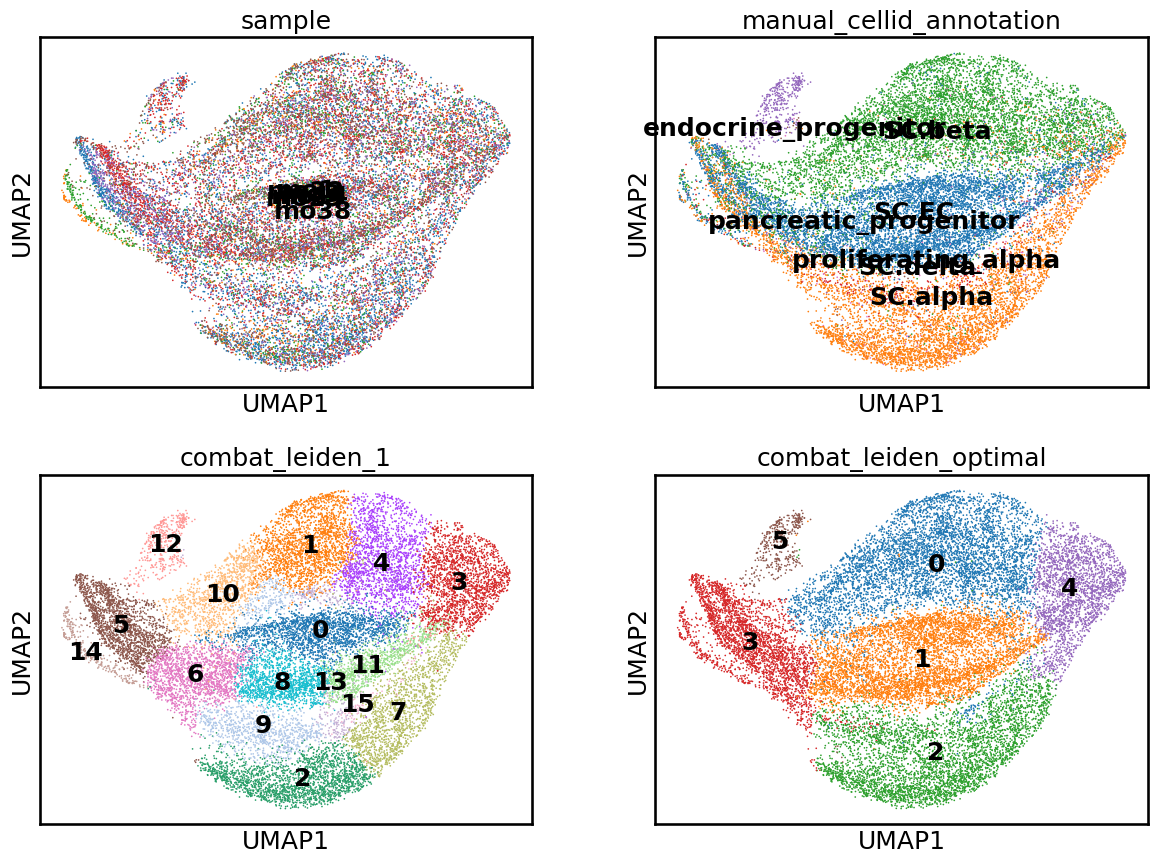

In [140]:
# Plot with sample colors
sc.pl.umap(
    adata_combat, 
    color=[
        "sample", 
        "manual_cellid_annotation", 
        f"combat_leiden_{leiden_resolution}", 
        "combat_leiden_optimal"
    ], 
    ncols=2, 
    legend_loc="on data"
)

# Scanorama
TODO

# BBKNN

In [ ]:
neighbors_within_batch = 25 if adata_hvg.n_obs > 100000 else 3

3

In [ ]:
adata_bbknn = adata_hvg.copy()
adata_bbknn.X = adata_bbknn.layers["logcounts"].copy()
sc.pp.pca(adata_bbknn)

In [ ]:
bbknn.bbknn(
    adata_bbknn, batch_key=batch_key, neighbors_within_batch=neighbors_within_batch
)
adata_bbknn

AnnData object with n_obs × n_vars = 20552 × 3000
    obs: 'n_genes', 'gex_barcode_cellranger', 'atac_barcode_cellranger', 'is_cell_cellranger', 'excluded_reason_cellranger', 'gex_raw_reads_cellranger', 'gex_mapped_reads_cellranger', 'gex_conf_intergenic_reads_cellranger', 'gex_conf_exonic_reads_cellranger', 'gex_conf_intronic_reads_cellranger', 'gex_conf_exonic_unique_reads_cellranger', 'gex_conf_exonic_antisense_reads_cellranger', 'gex_conf_exonic_dup_reads_cellranger', 'gex_exonic_umis_cellranger', 'gex_conf_intronic_unique_reads_cellranger', 'gex_conf_intronic_antisense_reads_cellranger', 'gex_conf_intronic_dup_reads_cellranger', 'gex_intronic_umis_cellranger', 'gex_conf_txomic_unique_reads_cellranger', 'gex_umis_count_cellranger', 'gex_genes_count_cellranger', 'atac_raw_reads_cellranger', 'atac_unmapped_reads_cellranger', 'atac_lowmapq_cellranger', 'atac_dup_reads_cellranger', 'atac_chimeric_reads_cellranger', 'atac_mitochondrial_reads_cellranger', 'atac_fragments_cellranger', 'at

In [ ]:
sc.tl.umap(adata_bbknn)

In [ ]:
sc.tl.leiden(adata_bbknn, key_added="bbknn_leiden", resolution=leiden_resolution)

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


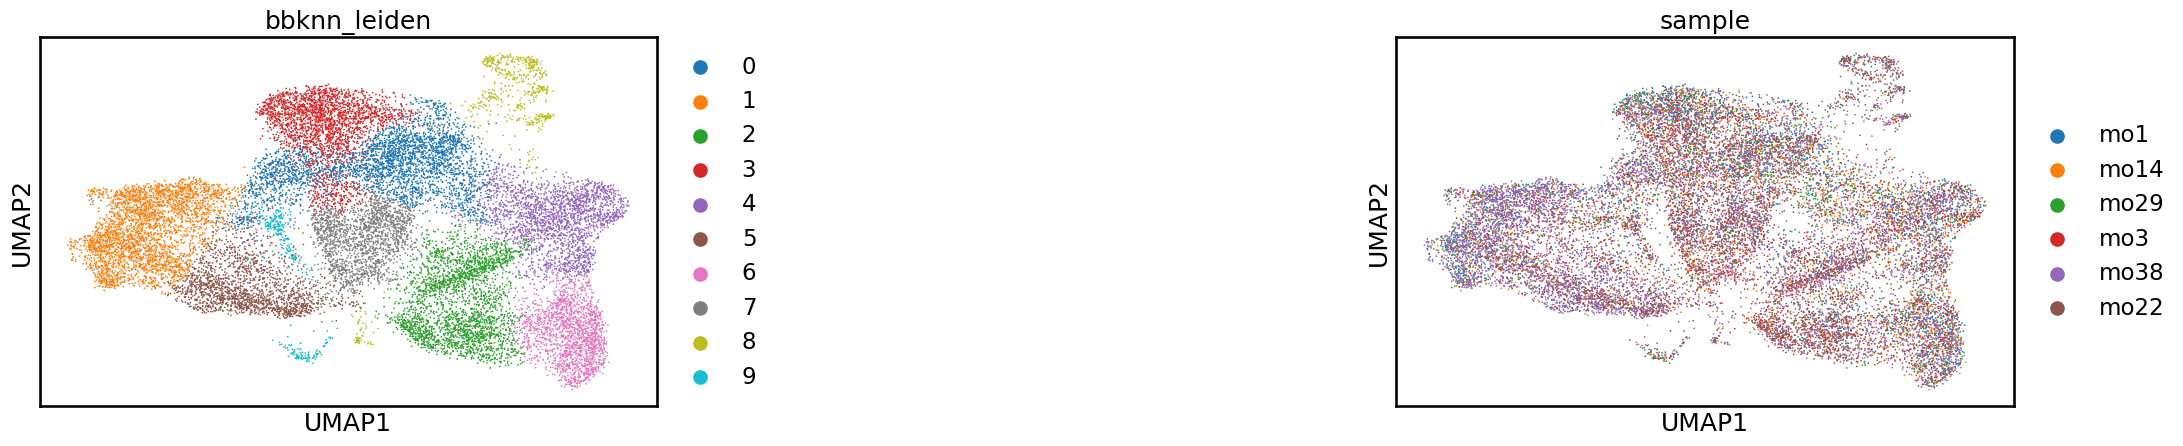

In [ ]:
sc.pl.umap(adata_bbknn, color=["bbknn_leiden", batch_key], wspace=1)

# Metrics

In [84]:
metrics_harmony_py = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_harmony_py, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca_harmony",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [142]:
metrics_harmony_R = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_harmony_R, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca_harmony",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [143]:
metrics_seurat = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_seurat, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [144]:
metrics_combat = scib.metrics.metrics_fast(
    adata_sctransform, 
    adata_combat, 
    batch_key="sample", 
    label_key="manual_cellid_annotation", 
    embed="X_pca",
)

Silhouette score...
PC regression...


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/anndata/_core/anndata.py:453: PendingDeprecationWarning: The dtype argument will be deprecated in anndata 0.10.0
  warnings.warn(


Isolated labels ASW...
Graph connectivity...


In [146]:
# Concatenate metrics results
metrics = pd.concat(
    [metrics_harmony_py, metrics_harmony_R, metrics_seurat, metrics_combat],
    axis="columns",
)
# Set methods as column names
metrics = metrics.set_axis(
    ["harmony_py", "harmony_R", "seurat", "combat", "unintegrated"], axis="columns"
)
# Select only the fast metrics
metrics = metrics.loc[
    [
        "ASW_label",
        "ASW_label/batch",
        "PCR_batch",
        "isolated_label_silhouette",
        "graph_conn",
        "hvg_overlap",
    ],
    :,
]
# Transpose so that metrics are columns and methods are rows
metrics = metrics.T
# Remove the HVG overlap metric because it's not relevant to embedding outputs
metrics = metrics.drop(columns=["hvg_overlap"])
metrics

ASW_label  ASW_label/batch  PCR_batch  isolated_label_silhouette  \
harmony_py   0.558886         0.895046   0.693722                   0.475158   
harmony_R    0.558656         0.894153   0.690563                   0.469316   
seurat       0.580533         0.895680   0.000582                   0.538239   
combat       0.499654         0.901760   0.993655                   0.434517   

            graph_conn  
harmony_py    0.872466  
harmony_R     0.888503  
seurat        0.858998  
combat        0.735233

In [147]:
metrics.style.background_gradient(cmap="Blues")

In [148]:
metrics_scaled = (metrics - metrics.min()) / (metrics.max() - metrics.min())
metrics_scaled.style.background_gradient(cmap="Blues")

In [149]:
metrics_scaled["Batch"] = metrics_scaled[
    ["ASW_label/batch", "PCR_batch", "graph_conn"]
].mean(axis=1)
metrics_scaled["Bio"] = metrics_scaled[["ASW_label", "isolated_label_silhouette"]].mean(
    axis=1
)
metrics_scaled.style.background_gradient(cmap="Blues")

# scvi-tools
TODO: The imports currently fail with the scverse-py39-R431 enviroment, but work with the scverse-py38-R431. For now I branched off the scVI run into a separate notebook because scvi-tools requires Python >= 3.9 to run

# DONE!

---

# Scratch

## Packages

In [157]:
import harmony

In [158]:
import scanorama

In [152]:
import trvae

ModuleNotFoundError: No module named 'trvae'

In [160]:
import mnnpy

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float32[:](float32[:, :]), nogil=True)
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: No implementation of function Function(<function norm at 0x155530cc0310>) found for signature:
 
 >>> norm(x=array(float32, 2d, A), axis=Literal[int](1))
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:24: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit(float32[:, :](float32[:, :], float32[:, :]))
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:29: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 1, 'A', False, aligned=True))
  dist[i, j] = np.dot(m[i], n[j])
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/mnnpy/utils.py:88: NumbaDeprecationWarning: The 'nopython' keyword argument was not suppl

In [154]:
import bbknn

In [159]:
import harmonypy

## Cluster proportions

In [ ]:
# Get the cluster proportions across samples
cross_tab = pd.crosstab(adata_concat.obs["sample"], adata_concat.obs["unintegrated_leiden"])
cross_tab_norm = cross_tab.div(cross_tab.sum(axis=1), axis=0)
cross_tab_norm

unintegrated_leiden         0         1         2         3         4  \
sample                                                                  
mo1                  0.303021  0.140654  0.082756  0.071429  0.119572   
mo14                 0.236230  0.109343  0.097511  0.088535  0.139943   
mo29                 0.228283  0.198653  0.046465  0.037710  0.115152   
mo3                  0.180663  0.111856  0.178899  0.143613  0.103387   
mo38                 0.142646  0.255089  0.113099  0.089297  0.092745   
mo22                 0.166223  0.085550  0.207668  0.161569  0.088652   

unintegrated_leiden         5         6         7         8         9  
sample                                                                 
mo1                  0.045941  0.131529  0.063877  0.018565  0.022656  
mo14                 0.044472  0.126071  0.115463  0.018360  0.024072  
mo29                 0.037710  0.103704  0.174411  0.035017  0.022896  
mo3                  0.095272  0.076217  0.071277  0.020113  0.018701  
mo38                 0.130499  0.063198  0.071241  0.030696  0.011490  
mo22                 0.109707  0.063608  0.048094  0.054965  0.013963

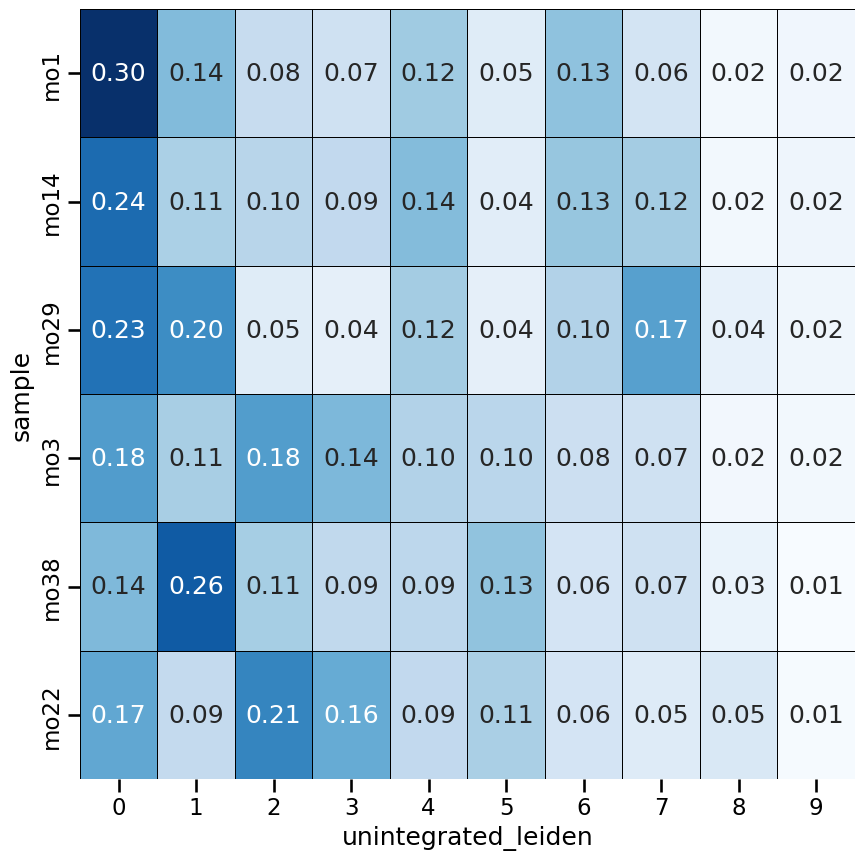

In [ ]:
# Plot heatmap with 2 decimal places and make sure its wide enough
plt.figure(figsize=(10, 10))
sns.heatmap(cross_tab_norm, annot=True, fmt=".2f", cmap="Blues", linewidths=0.5, linecolor="black", cbar=False)
plt.show()

## Old Harmony integration code

In [ ]:
%%R
# Need PCA
sobj = RunPCA(sobj, verbose = FALSE)

In [ ]:
%%R
# Run Harmony
sobj <- RunHarmony(
    object = sobj,
    group.by.vars = c('sample'),
    assay.use = 'SCT',
    max.iter.harmony=25,
    project.dim = FALSE
)

R[write to console]: Transposing data matrix

R[write to console]: Initializing state using k-means centroids initialization

R[write to console]: Harmony 1/10

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: 

In [ ]:
%%R -o harmony_embedding -o umap_harmony_embedding -o harmony_clusters
# With Harmony
sobj = FindNeighbors(sobj, reduction = "harmony", dims = 1:30, graph.name=c("harmony_knn", 'harmony_snn'))
sobj = FindClusters(sobj, resolution = 1, graph.name = 'harmony_snn', algorithm = 4, verbose = TRUE)
sobj = RunUMAP(sobj, reduction = "harmony", dims = 1:30, reduction.name='umap.harmony', reduction.key='harmonyUMAP_', verbose = FALSE)
harmony_embedding = Embeddings(sobj, reduction = "harmony")
umap_harmony_embedding = Embeddings(sobj, reduction = "umap.harmony")
harmony_clusters = sobj$seurat_clusters
sobj$harmony_clusters = harmony_clusters

R[write to console]: Computing nearest neighbor graph

R[write to console]: Computing SNN



In [ ]:
# Add in the harmony embeddings
adata_concat.obsm["X_sctransform_pca_harmony"] = harmony_embedding
adata_concat.obsm["X_sctransform_pca_harmony_umap"] = umap_harmony_embedding
adata_concat.obs["harmony_sctransform_leiden_1"] = harmony_clusters

In [ ]:
# Get the UMAP ready to plot
adata_concat.obsm["X_umap"] = adata_concat.obsm["X_sctransform_pca_harmony_umap"]

/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/cellar/users/aklie/opt/miniconda3/envs/scverse-py38-R431/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


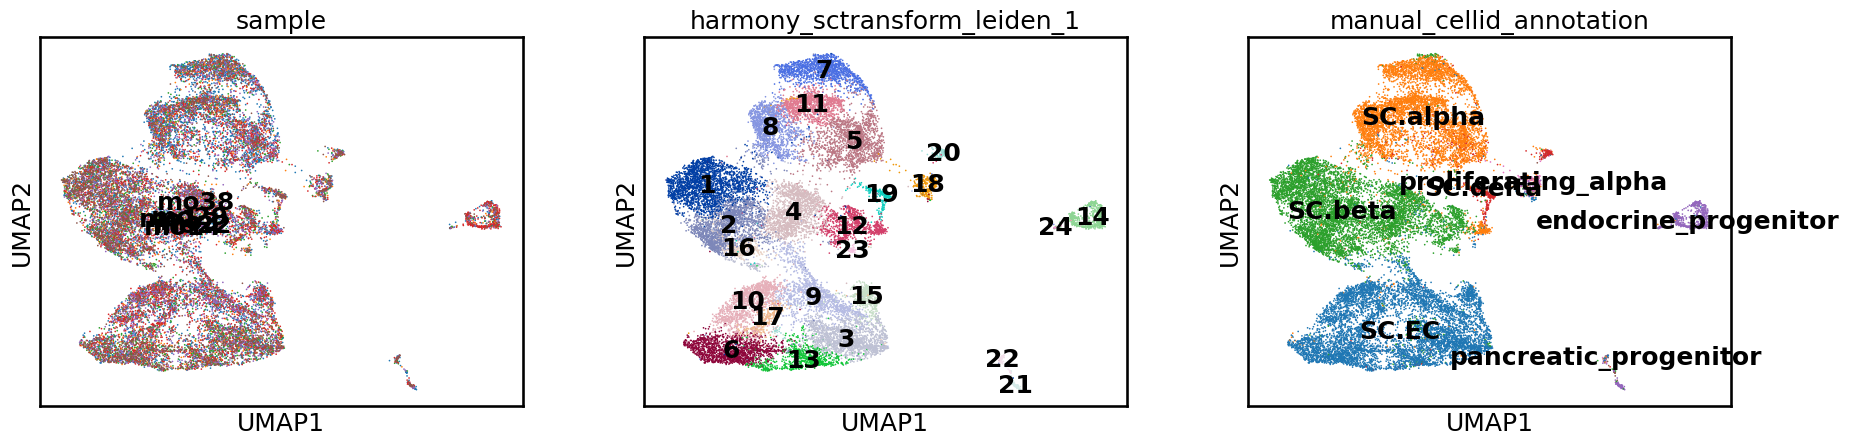

In [ ]:
# Plot with sample colors
sc.pl.umap(adata_concat, color=["sample", "harmony_sctransform_leiden_1", "manual_cellid_annotation"], legend_loc="on data")